In [148]:
import os
import time
import sys
import scipy
import glob
import importlib
import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.use('nbagg')
import seaborn as sns
import pylab as pl

from datetime import datetime

# import some custom funcs
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils as util
import behavior as butil

In [149]:
importlib.reload(util)

<module 'utils' from '/Users/julianarhee/Repositories/plume-tracking/utils.py'>

In [150]:
util.set_sns_style(style='dark', min_fontsize=12)
%matplotlib notebook


In [151]:
# rootdir = '/mnt/minerva/plume-tracking/behavior'
rootdir = '/Volumes/Julie/plume-tracking/behavior'
experiment = 'strip_grid'

srcdir = os.path.join(rootdir, experiment)
logdir = os.path.join(srcdir, 'logfiles')

figdir = os.path.join(srcdir, 'figures')
if not os.path.exists(figdir):
    os.makedirs(figdir)
print("Saving figures to: {}".format(figdir))

fig_id = srcdir

Saving figures to: /Volumes/Julie/plume-tracking/behavior/strip_grid/figures


In [5]:
# # root_dir = '/Users/julianarhee/Library/CloudStorage/GoogleDrive-edge.tracking.ru@gmail.com/My Drive/Edge_Tracking/Data'
# rootdir = util.get_rootdir()
# experiment = 'vertical_strip/paired_experiments'
# src_dir = os.path.join(rootdir, experiment)

# fig_id = os.path.join('/Edge_Tracking', rootdir.split('/Edge_Tracking/')[1], experiment)
# print(fig_id)
# savedir = '{}/jyr/{}'.format(rootdir, experiment)
# savedir = savedir.replace(" ", "")
# figdir = os.path.join(savedir, 'figures')
# print("Saving figures to:{}    {}".format('\n', figdir))
# if not os.path.exists(figdir):
#     os.makedirs(figdir)

# load df

In [185]:
# fn = '20230126-175229_strip_grid_fly1_001.log'
# fn = '20230112-155809_strip_grid_fly4_000.log'
# fn = '20230112-110700_strip_grid_fly1_002.log'
# fn = '20230111-140918_strip_grid_fly1_000.log'
# fn = '20230105-182650_strip_grid_fly1_004.log'
fn = '20230106-121556_strip_grid_fly1_000.log'

fpath = os.path.join(logdir, fn)
config  = butil.load_experiment_config(fpath)
#if config is not 
strip_width = config['experiment']['strip_width'] if config is not None else 20 #50
if fn in ['20230106-121556_strip_grid_fly1_000.log', '20230105-182650_strip_grid_fly1_004.log']:
    strip_sep_default = 200
else:
    strip_sep_default = 400
strip_sep = config['experiment']['strip_spacing'] if config is not None else strip_sep_default # 400

df0_full = butil.load_dataframe(fpath, remove_invalid=False)
df0_full = butil.process_df(df0_full)

odor_ix = df0_full[df0_full['instrip']].iloc[0].name
df0 = df0_full.loc[odor_ix:].copy()

odor_bounds = butil.find_strip_borders(df0_full, entry_ix=odor_ix,
                                       strip_width=strip_width, strip_sep=strip_sep)
odor_bounds

[(-136.65043162432403, -116.57911193505299),
 (83.20442544883613, 103.35916597671547),
 (303.05928252199635, 323.42446466398496)]

In [186]:
importlib.reload(butil)

<module 'behavior' from '/Users/julianarhee/Repositories/plume-tracking/behavior.py'>

<IPython.core.display.Javascript object>


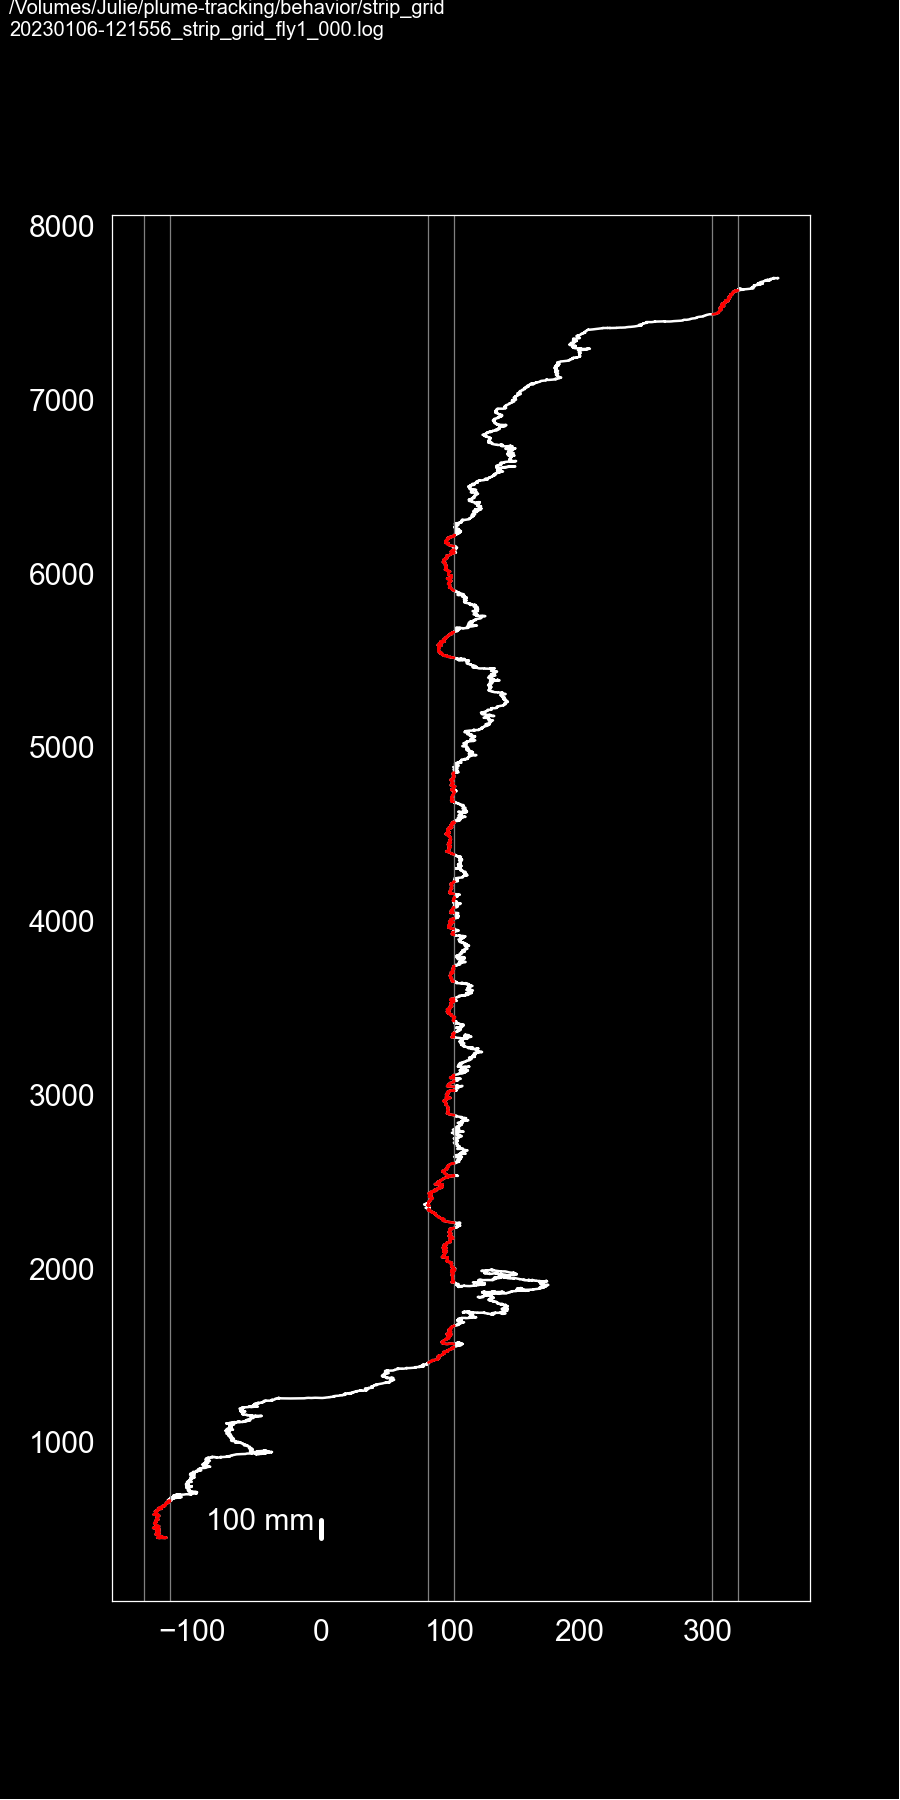

In [187]:
fig, ax = pl.subplots(figsize=(5, 10)) #, dpi=300)
# sns.lineplot(x='ft_posx', y='ft_posy', data=df_, ax=ax)
ax.plot(df0['ft_posx'], df0['ft_posy'], lw=1, c='w')
#ax.set_aspect(1)
for ob in odor_bounds:
    butil.plot_odor_corridor(ax, odor_xmin=ob[0], 
                         odor_xmax=ob[1], odor_linewidth=0.5)
for bnum, b_ in df0[df0['instrip']].groupby('boutnum'):
    ax.plot(b_['ft_posx'], b_['ft_posy'], lw=1, c='r')
#ax.set_xlim([0, 250])
#ax.set_yticks([500, 550, 600])
# ax.set_yticklabels(['', '100 mm', ''])
# for pos in ['right', 'top', 'bottom', 'left']:
#    pl.gca().spines[pos].set_visible(False)
leg_xpos=0; leg_ypos=round(df0.loc[odor_ix]['ft_posy']); leg_scale=100
butil.vertical_scalebar(ax, leg_xpos=leg_xpos, leg_ypos=leg_ypos)
# ax.plot([leg_xpos, leg_xpos], [leg_ypos, leg_ypos+leg_scale], 'w', lw=2)
# ax.text(leg_xpos-250, leg_ypos+(leg_scale/2), '{} mm'.format(leg_scale), fontsize=12)
#ax.axis('off')

curr_figid = '{}{}{}'.format(srcdir, '\n', os.path.split(fpath)[-1])
util.label_figure(fig, curr_figid)
fly_id = os.path.splitext(os.path.split(fpath)[-1])[0]
figname = '{}_odortraj'.format(fly_id)

pl.savefig(os.path.join(figdir, '{}.png'.format(figname)), dpi=300)
pl.savefig(os.path.join(figdir, '{}.svg'.format(figname)))#, dpi=300)

In [191]:
odor_bounds

[(-136.65043162432403, -116.57911193505299),
 (83.20442544883613, 103.35916597671547),
 (303.05928252199635, 323.42446466398496)]

# find ET bouts

In [193]:
et_bouts = {}
et_boutstats = {}
for oi, ob in enumerate(odor_bounds):
    if len(odor_bounds)>1:
        curr_ob_min = min(ob)
        next_ob_min = max(ob)+strip_sep/2. #min(odor_bounds[oi+1]) if oi<(len(odor_bounds)-1) else max(ob)
        # get df up until *next* odor strip
        within_bounds = df0[ (df0['instrip']) \
                            & (df0['ft_posx']>=curr_ob_min) \
                            & (df0['ft_posx'] < next_ob_min)].copy()        
        #df_ = df0[ (df0['ft_poxs']>=curr_ob_min) & (df0['ft_posx'] < next_ob_min)].copy()
        start_bout, end_bout = within_bounds['boutnum'].min(), within_bounds['boutnum'].max()
        df_ = df0[(df0['boutnum']>=start_bout) & (df0['boutnum']<=end_bout)].copy()
        print(oi, start_bout, end_bout, next_ob_min, df_.shape)
    else:
        df_ = df0.copy()
        start_bout = df0[df0['instrip']].iloc[0]['boutnum'].min() + 1 # start from 1st outbout
        end_bout = df0[df0['instrip']]['boutnum'].max()
    if df_.shape[0]==0:
        continue
    print( "{}: starts instrip {}".format(oi, df_['instrip'].iloc[0]))
    # calculate duration and N in/outbouts of current ET bout
    #start_bout = df_[df_['instrip']].iloc[0]['boutnum']+1 # measure from first outbout
    #end_bout = df_[df_['instrip']]['boutnum'].max() # until last inbout

    measure_bout = df_[(df_['boutnum']>=start_bout) & (df_['boutnum']<=end_bout)].copy()
    upwind_dist = measure_bout['upwind_dist'].sum()
    n_bouts = len(measure_bout['boutnum'].unique())
    entry_ix = df_[df_['ft_posx']>ob[0]].iloc[0].name
    et_boutstats.update({
        oi: {
            'upwind_dist': upwind_dist,
            'n_bouts': n_bouts,
            'key': 'c{}'.format(entry_ix)
        }
    })
    # check if ET
    is_et = butil.is_edgetracking(df_, strip_width=strip_width, \
                        min_outside_bouts=3, min_upwind_dist=200)
    if is_et:
        print("Is ET:", oi, is_et)
        et_bouts.update({'c{}'.format(entry_ix): ob})
et_bouts  

0 2 2 -16.579111935052993 (1225, 40)
0: starts instrip True
1 4 56 203.35916597671547 (47932, 40)
1: starts instrip True
Is ET: 1 True
2 58 58 423.42446466398496 (680, 40)
2: starts instrip True


{'c16852': (83.20442544883613, 103.35916597671547)}

# pick best ET bout

In [194]:
sorted_ets = sorted(list(et_boutstats.values()), \
               key=lambda k: (float(k['upwind_dist']), k['n_bouts']), reverse=True)
et_id = [k for k, v in et_boutstats.items() \
         if all([v[i]==sorted_ets[0][i] for i in list(v.keys())])][0]
#et_id = list(et_bouts.keys())[0]
print(et_id)
sorted_ets

1


[{'upwind_dist': 4764.363961000589, 'n_bouts': 53, 'key': 'c16852'},
 {'upwind_dist': 214.27715190287995, 'n_bouts': 1, 'key': 'c5483'},
 {'upwind_dist': 137.87790171419965, 'n_bouts': 1, 'key': 'c76183'}]

# select best ET bout

In [195]:
et_boutkey = et_boutstats[et_id]['key']
print(et_boutkey)
# select from 
next_ob = et_bouts[et_boutkey][0]
# print(next_ob)
# start from previou outbout, if exists
odor_ix = df0_full[df0_full['ft_posx']>=next_ob].iloc[0].name
et_startbout = df0_full.loc[odor_ix]['boutnum'] #-1
# make sure not including another strip, if exists
past_current_strip_x = et_bouts[et_boutkey][1] + strip_sep/2
et_lastbout = df0_full[ (df0_full['instrip']) \
                       & (df0_full['ft_posx']>=past_current_strip_x)]['boutnum'].min()
if et_lastbout is not np.nan:
    et_lastbout -= 1
else:
    et_lastbout = df0_full['boutnum'].max()
print(et_startbout, et_lastbout)
df0 = df0_full[(df0_full['boutnum']>=et_startbout)
              & (df0_full['boutnum']<=et_lastbout)].copy() # include prev bout for "entry into" odor 

df = df0.loc[odor_ix:].copy()

c16852
3 57


<IPython.core.display.Javascript object>


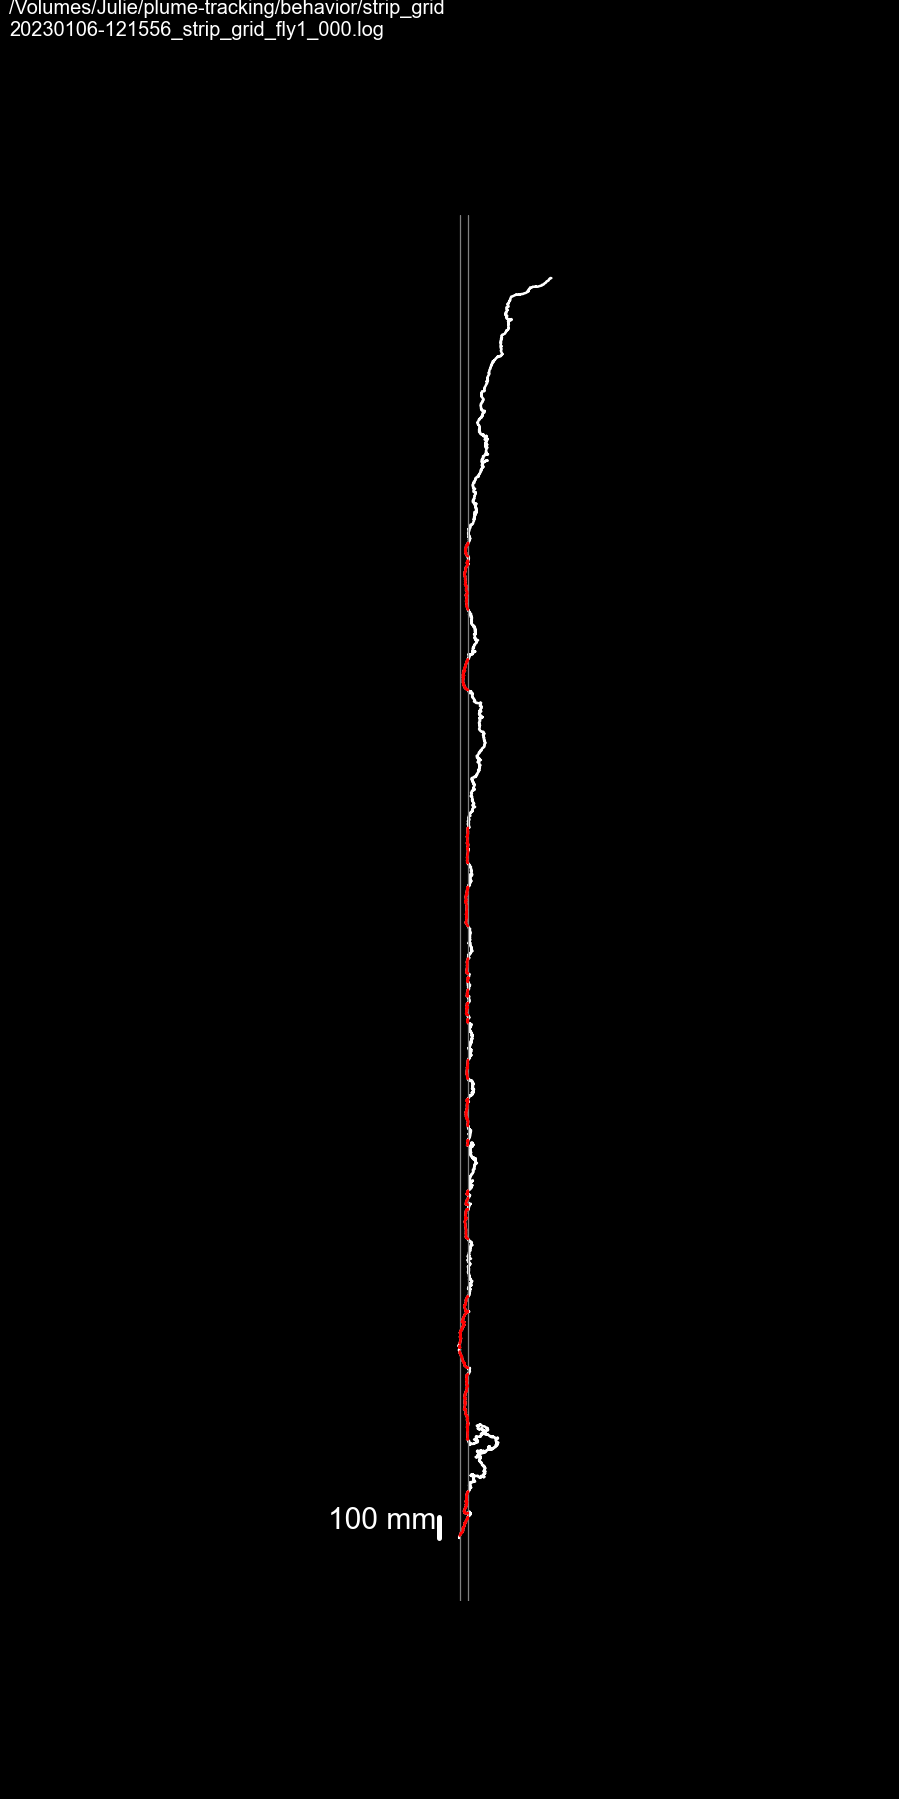

In [196]:
# - plot current et bout
fig, ax = pl.subplots(figsize=(5, 10)) #, dpi=300)
ax.plot(df['ft_posx'], df['ft_posy'], lw=1, c='w')
ax.set_aspect(0.5)
obounds = [et_bouts[et_boutkey]]
butil.plot_odor_corridor(ax, odor_xmin=obounds[0][0], 
                         odor_xmax=obounds[0][1], odor_linewidth=0.5)
for bnum, b_ in df[df['instrip']].groupby('boutnum'):
    ax.plot(b_['ft_posx'], b_['ft_posy'], lw=1, c='r')
# legend    
leg_xpos=round(df.iloc[0]['ft_posx'])-50; leg_ypos=round(df.iloc[0]['ft_posy']); leg_scale=100
butil.vertical_scalebar(ax, leg_xpos=leg_xpos, leg_ypos=leg_ypos, leg_scale=leg_scale)
ax.axis('off')
pl.subplots_adjust(left=0.2)
util.label_figure(fig, curr_figid)

figname = '{}_odortraj-bout{}'.format(fly_id, et_id)
pl.savefig(os.path.join(figdir, '{}.png'.format(figname)), dpi=300)
pl.savefig(os.path.join(figdir, '{}.svg'.format(figname)))#, dpi=300)


In [197]:
obounds

[(83.20442544883613, 103.35916597671547)]

## flip so most entries coming in from right edge

In [198]:
importlib.reload(butil)

<module 'behavior' from '/Users/julianarhee/Repositories/plume-tracking/behavior.py'>

In [199]:
et_bouts = dict((k, v) for k, v in et_bouts.items() if k==et_boutkey)
et_bouts

{'c16852': (83.20442544883613, 103.35916597671547)}

In [200]:
et_boutkey

'c16852'

In [201]:
all_et_starts = [int(v['key'][1:]) for k, v in et_boutstats.items()]
all_et_starts

[5483, 16852, 76183]

In [202]:
tmp_start_ix = int(et_boutkey[1:])-1
ix = all_et_starts.index(tmp_start_ix+1)
if len(all_et_starts)>1:
    tmp_end_ix = all_et_starts[ix+1] if tmp_start_ix < max(all_et_starts) else df0_full.iloc[-1].name
else:
    tmp_end_ix = df0_full.iloc[-1].name
print(tmp_start_ix, tmp_end_ix)
dfp, obounds_fp = butil.check_entryside_and_flip(df0_full.loc[tmp_start_ix:tmp_end_ix].copy(), 
                                        odor_dict=et_bouts,
                                     strip_width=strip_width)
dfp['flipped'].unique()

16851 76183
Not flipping borders


array([False])

<IPython.core.display.Javascript object>


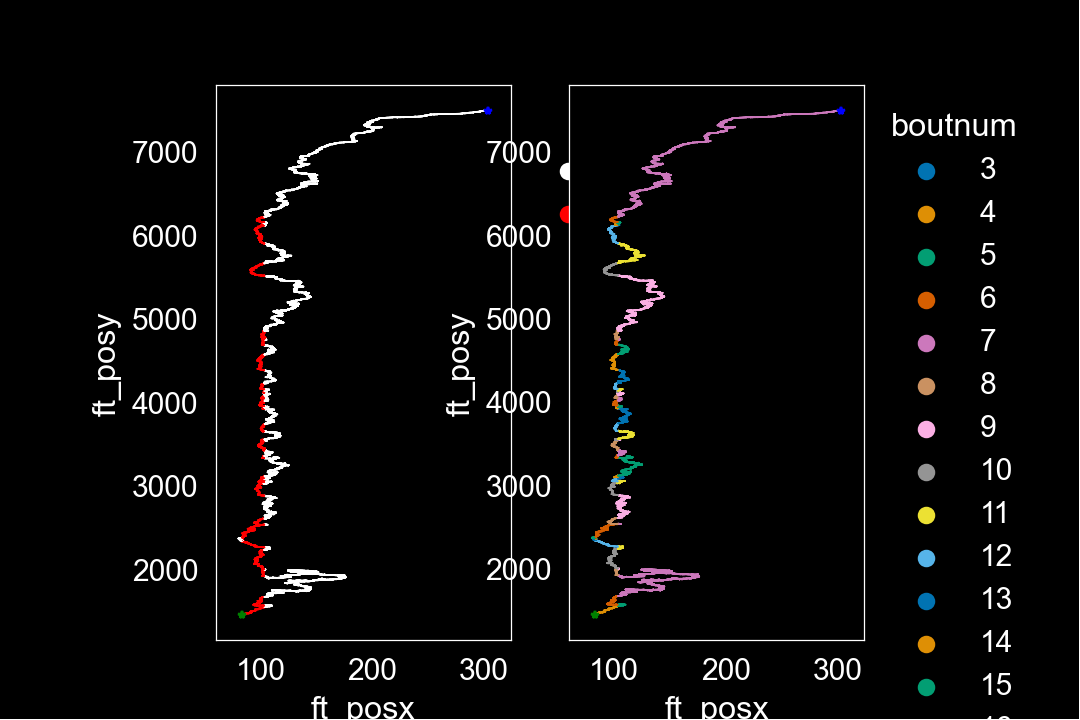

<AxesSubplot: xlabel='ft_posx', ylabel='ft_posy'>

In [203]:
fig, axn =pl.subplots(1,2)
ax=axn[0]
butil.plot_trajectory(dfp, ax=ax)
ax=axn[1]
butil.plot_trajectory(df,hue_varname='boutnum', palette='colorblind', ax=ax)

<IPython.core.display.Javascript object>


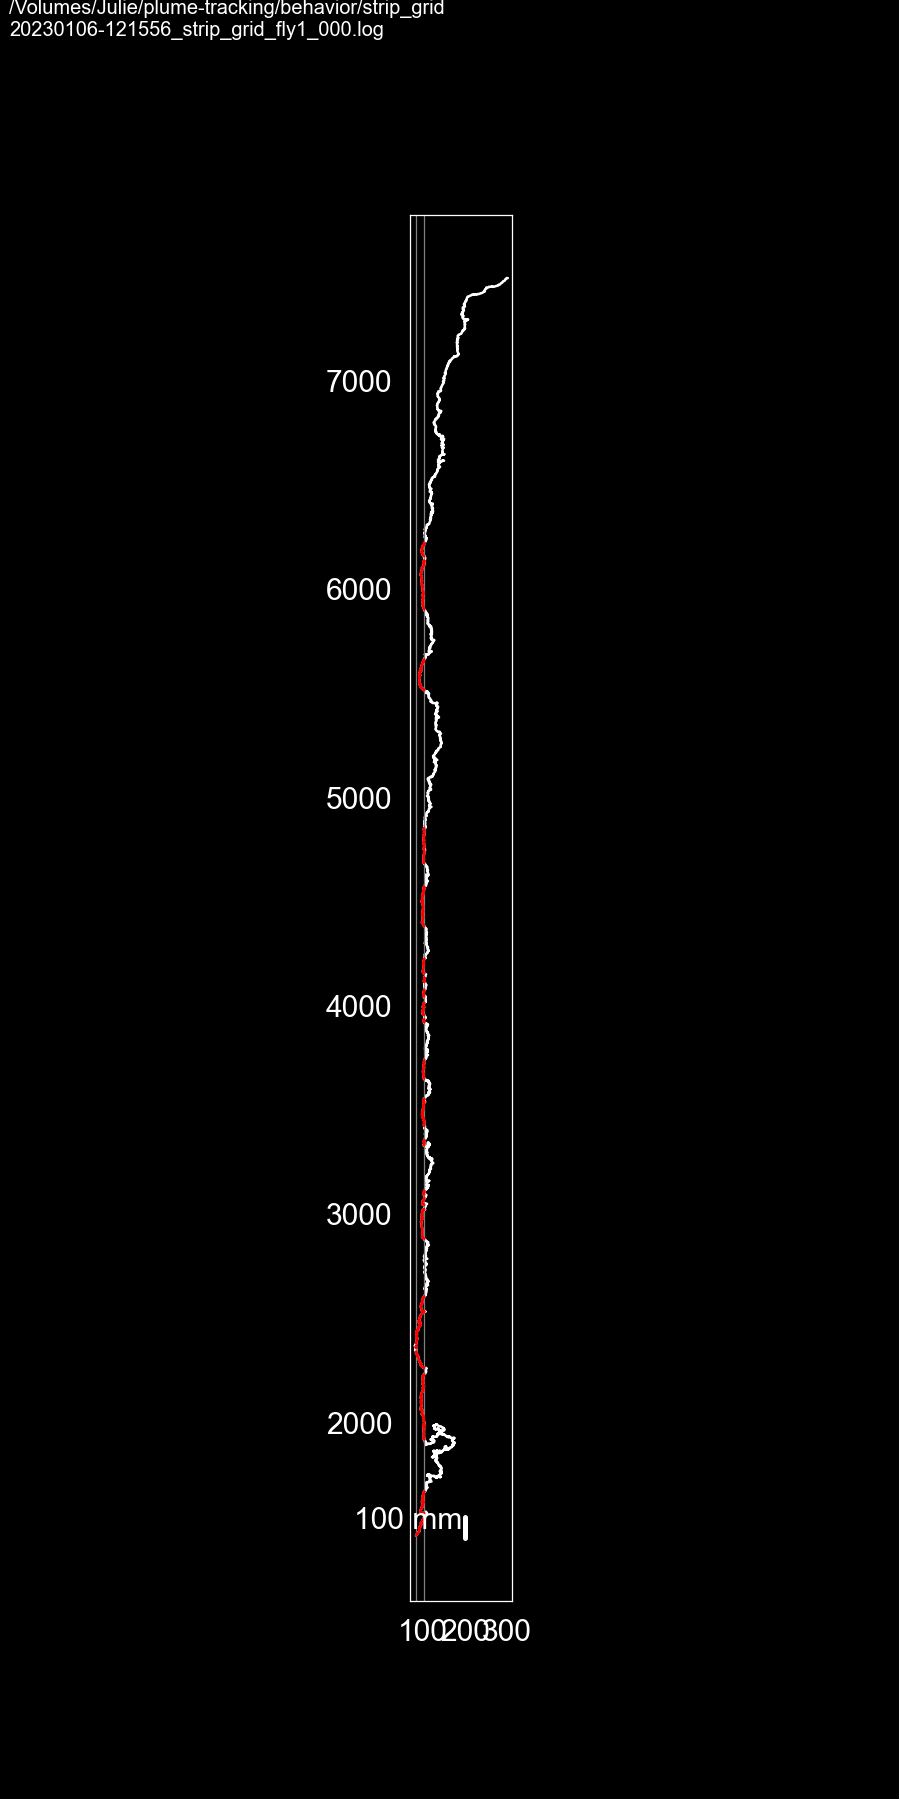

In [204]:
# - plot current et bout
fig, ax = pl.subplots(figsize=(5, 10)) #, dpi=300)
ax.plot(dfp['ft_posx'], dfp['ft_posy'], lw=1, c='w')
ax.set_aspect(.5)
obounds = list(obounds_fp.values()) #[et_bouts[et_id]]
butil.plot_odor_corridor(ax, odor_xmin=obounds[0][0],  
                         odor_xmax=obounds[0][1], odor_linewidth=0.5)
for bnum, b_ in dfp[dfp['instrip']].groupby('boutnum'):
    ax.plot(b_['ft_posx'], b_['ft_posy'], lw=1, c='r')
# legend    
leg_xpos=200; leg_ypos=round(df.iloc[0]['ft_posy']); leg_scale=100
butil.vertical_scalebar(ax, leg_xpos=leg_xpos, leg_ypos=leg_ypos, leg_scale=leg_scale)
util.label_figure(fig, curr_figid)


In [205]:
df['boutnum'].min(), df['boutnum'].max()

(3, 57)

In [206]:
df = dfp.loc[odor_ix:].copy()
obounds = list(obounds_fp.values())

In [207]:
obounds_fp

{'c16852': (83.20442544883613, 103.35916597671547)}

In [208]:
obounds

[(83.20442544883613, 103.35916597671547)]

<IPython.core.display.Javascript object>


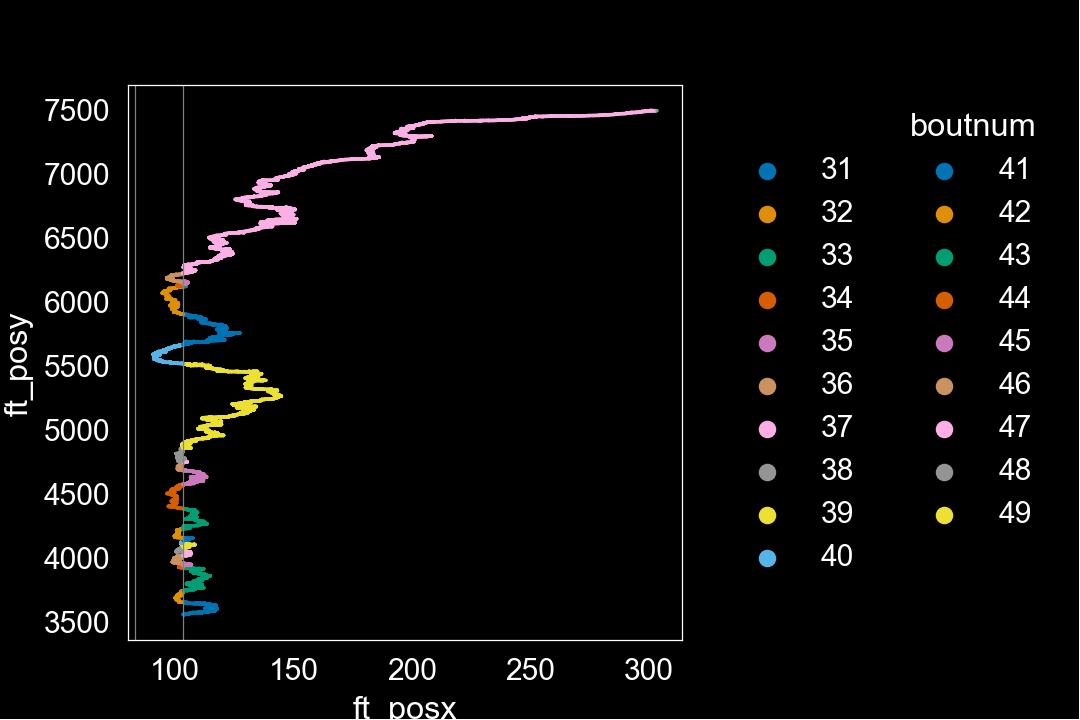

In [209]:
fig, ax = pl.subplots(figsize=(6,4))
sns.scatterplot(data=df[(df['boutnum']>30) & (df['boutnum']<60)], x='ft_posx', y='ft_posy', hue='boutnum',
                ax=ax, edgecolor='none', palette='colorblind', s=2)
ax.set_box_aspect(1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1), frameon=False, ncols=3)
butil.plot_odor_corridor(ax, odor_xmin=obounds[0][0], 
                         odor_xmax=obounds[0][1], odor_linewidth=0.5)
pl.subplots_adjust(left=0.05, right=0.7)

In [210]:
# boutdir_palette = {'outbound': 'lightskyblue', 'inbound': 'cyan'}
boutdir_palette = {'outbound': 'cyan', 'inbound': 'violet'} #'cyan'}

In [211]:
importlib.reload(butil)

<module 'behavior' from '/Users/julianarhee/Repositories/plume-tracking/behavior.py'>

Path length: outbound 619.02, inbound 422.42
Tortuosity: outbound 1.52, inbound 1.64
Efficiency (x): outbound 6.99, inbound 5.04


<IPython.core.display.Javascript object>


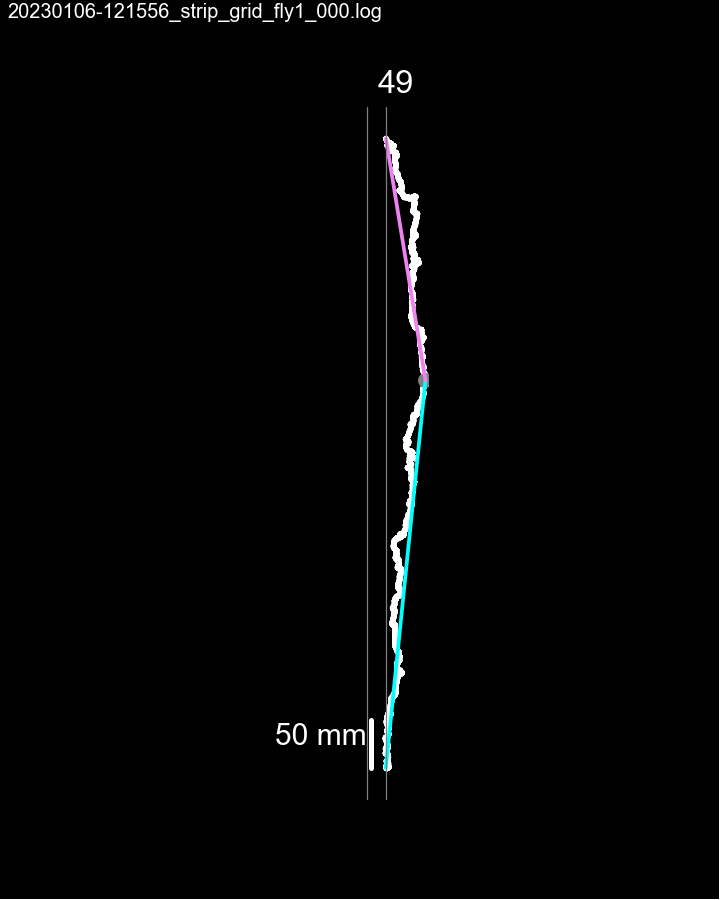

In [212]:
# bnum = 7 # 3#7 #5
# bnum = 21
# bnum = 31
# bnum = 33
# bnum = 39
bnum = 49
bdf = df[df['boutnum']==bnum].copy()

xvar = 'ft_posx'
yvar = 'ft_posy'
max_ix = np.argmax(bdf[xvar])
min_ix = np.argmin(bdf[xvar])
outbound_traj = bdf.iloc[0:max_ix][[xvar, yvar]].values
inbound_traj = bdf.iloc[max_ix:][[xvar, yvar]].values

# path length
pathlength_out = util.path_length(outbound_traj)
pathlength_in = util.path_length(inbound_traj)
print("Path length: outbound {:.2f}, inbound {:.2f}".format(pathlength_out, pathlength_in))
# tortuosity 
tort_outbound = util.calculate_tortuosity(outbound_traj)
tort_inbound = util.calculate_tortuosity(inbound_traj)
print("Tortuosity: outbound {:.2f}, inbound {:.2f}".format(tort_outbound, tort_inbound))
# efficiency of path
xpathlength_out = util.path_length(outbound_traj, axis='x')
xpathlength_in = util.path_length(inbound_traj, axis='x')
maxdist_x = bdf.iloc[max_ix][xvar] - bdf.iloc[min_ix][xvar]
print("Efficiency (x): outbound {:.2f}, inbound {:.2f}"\
      .format(xpathlength_out/maxdist_x, xpathlength_in/maxdist_x))
# plot
fig, ax = pl.subplots(figsize=(4,5))
sns.scatterplot(data=bdf, x='ft_posx', y='ft_posy', ax=ax,
                edgecolor='none', color='w', s=5)
ax.plot(bdf.iloc[max_ix]['ft_posx'], bdf.iloc[max_ix]['ft_posy'], 'o', c='gray', markersize=5)
ax.set_aspect(1)
# plot vectors
ax.plot([bdf.iloc[0][xvar], bdf.iloc[max_ix][xvar]], 
        [bdf.iloc[0][yvar], bdf.iloc[max_ix][yvar]], boutdir_palette['outbound'])
ax.plot([bdf.iloc[max_ix][xvar], bdf.iloc[-1][xvar]], 
        [bdf.iloc[max_ix][yvar], bdf.iloc[-1][yvar]], boutdir_palette['inbound'])
ax.set_title(bnum)
# odor corridor
butil.plot_odor_corridor(ax, odor_xmin=obounds[0][0], 
                         odor_xmax=obounds[0][1], odor_linewidth=0.5)
# legend    
leg_xpos=round(bdf.iloc[0]['ft_posx'])-15; 
leg_ypos=round(bdf.iloc[0]['ft_posy']); leg_scale=50
butil.vertical_scalebar(ax, leg_xpos=leg_xpos, leg_ypos=leg_ypos, leg_scale=leg_scale)
ax.axis('off')

pl.subplots_adjust(left=0.2)
util.label_figure(fig, curr_figid)
fly_id = os.path.splitext(os.path.split(fpath)[-1])[0]
figname = 'example-bout-{}_{}'.format(bnum, fly_id)

pl.savefig(os.path.join(figdir, '{}.png'.format(figname)), dpi=300)
pl.savefig(os.path.join(figdir, '{}.svg'.format(figname)))#, dpi=300)

# calculate tortuosity metrics

In [213]:
last_outbout = df[~df['instrip']]['boutnum'].max()
max_boutnum = df['boutnum'].max()
skip_last_bout = last_outbout==max_boutnum
skip_last_bout

False

In [214]:
xdist_cutoff = 1.9
d_list = []
for bnum, bdf in df[~df['instrip']].groupby('boutnum'):
    if bnum == last_outbout and skip_last_bout:
        continue
    max_ix = np.argmax(bdf[xvar])
    if max_ix==0: # this bout is flipped out to negative side, do flipLR
        bdf['ft_posx'], bdf['ft_posy'] = util.fliplr_coordinates(bdf['ft_posx'].values, \
                                         bdf['ft_posy'].values)
        max_ix = np.argmax(bdf[xvar])
        print(max_ix)
    min_ix = np.argmin(bdf[xvar])
    maxdist_x = bdf.iloc[max_ix][xvar] - bdf.iloc[min_ix][xvar]
    if maxdist_x < xdist_cutoff:
        continue
        
    outbound_traj = bdf.iloc[0:max_ix][[xvar, yvar]].values
    inbound_traj = bdf.iloc[max_ix:][[xvar, yvar]].values
    # path length
    pathlength_out = util.path_length(outbound_traj)
    pathlength_in = util.path_length(inbound_traj)
    # tortuosity 
    tort_outbound = util.calculate_tortuosity(outbound_traj)
    tort_inbound = util.calculate_tortuosity(inbound_traj)
    # efficiency of path
    xpathlength_out = util.path_length(outbound_traj, axis='x')
    xpathlength_in = util.path_length(inbound_traj, axis='x')
    
    # combine
    d_ = pd.DataFrame({
        'boutnum': [bnum]*2,
        'boutdir': ['outbound', 'inbound'],
        'pathlength': [pathlength_out, pathlength_in],
        'tortuosity': [tort_outbound, tort_inbound],
        'xpath_length': [xpathlength_out, xpathlength_in],
        'efficiency': [xpathlength_out/maxdist_x, xpathlength_in/maxdist_x],
        'maxdist_x': [maxdist_x]*2,
        'max_xpos': [bdf.iloc[max_ix]['ft_posx']]*2,
        'max_ix': [max_ix]*2,
    })
    
    d_list.append(d_)

tortdf = pd.concat(d_list,axis=0).reset_index(drop=True)
tortdf.head()

0


/Users/julianarhee/Repositories/plume-tracking/utils.py:111: RuntimeWarning: invalid value encountered in double_scalars
  tortuosity = pathlength/maxdist


,boutnum,boutdir,pathlength,tortuosity,xpath_length,efficiency,maxdist_x,max_xpos,max_ix
0,5,outbound,28.519722,1.632179,17.802997,2.643151,6.735522,110.137200,139
1,5,inbound,38.886547,5.769097,24.522404,3.640758,6.735522,110.137200,139
2,7,outbound,783.121203,3.189140,453.535214,6.224660,72.861040,176.304729,5836
3,7,inbound,494.746793,6.653288,296.254902,4.066026,72.861040,176.304729,5836
4,11,outbound,18.157085,1.268484,7.990475,1.712660,4.665534,108.128044,97


<IPython.core.display.Javascript object>


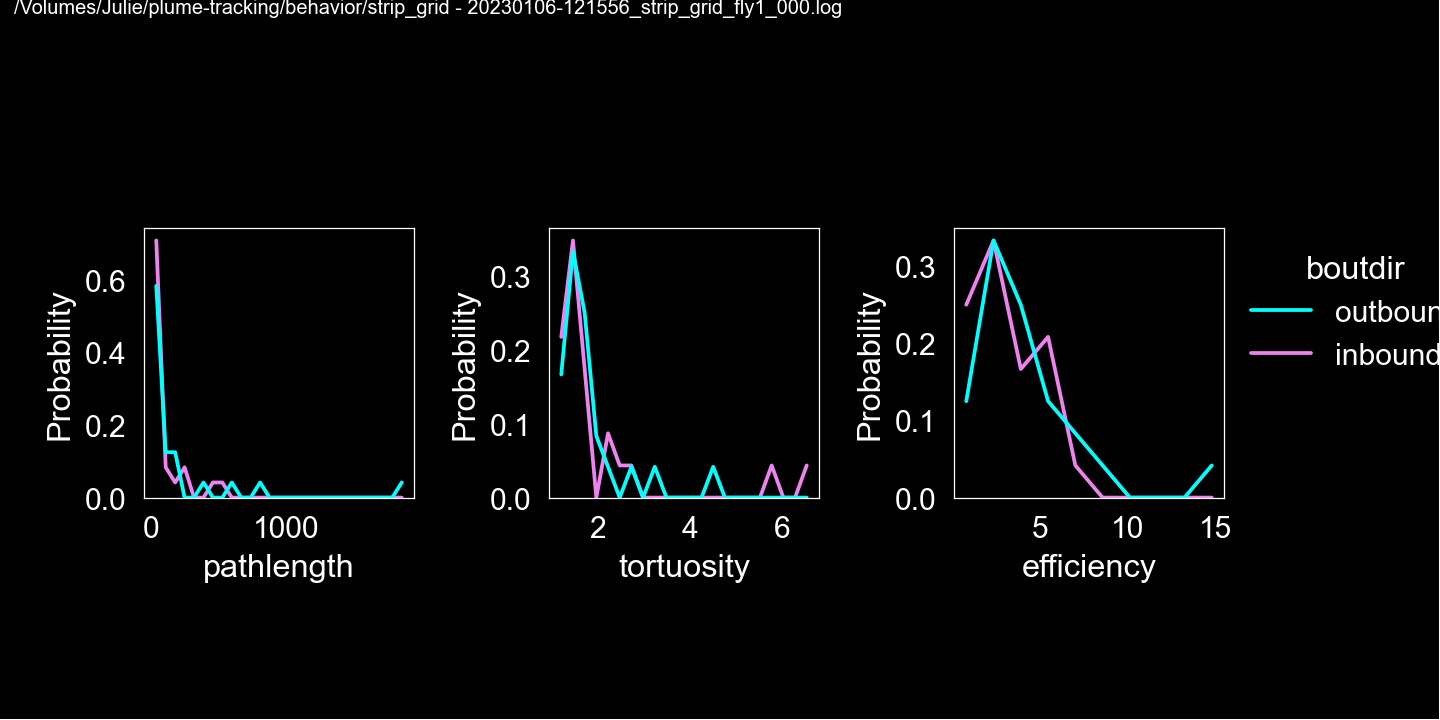

tortuosity-metrics-hist_20230106-121556_strip_grid_fly1_000


In [215]:
cdf = False
fig, axn = pl.subplots(1, 3, figsize=(8,4))
ax=axn[0]
ax=sns.histplot(data=tortdf, x='pathlength', hue='boutdir', ax=ax, palette=boutdir_palette,
             cumulative=cdf, fill=False, element='poly', stat='probability',
             common_norm=False)
ax=axn[1]
ax=sns.histplot(data=tortdf, x='tortuosity', hue='boutdir', ax=ax, palette=boutdir_palette,
             cumulative=cdf, fill=False, element='poly', stat='probability',
             common_norm=False)
ax=axn[2]
ax=sns.histplot(data=tortdf, x='efficiency', hue='boutdir', ax=ax, palette=boutdir_palette,
             cumulative=cdf, fill=False, element='poly', stat='probability',
             common_norm=False)
for ai, ax in enumerate(axn):
    ax.set_box_aspect(1)
    if ai==2:
        h, l = ax.get_legend_handles_labels()
        #l = ax.legend_data.keys()
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
    else:
        ax.legend_.remove()
pl.subplots_adjust(left=0.1, right=0.85, wspace=0.5)

util.label_figure(fig, "{} - {}".format(fig_id, fn))
figname = 'tortuosity-metrics-hist_{}'.format(os.path.splitext(fn)[0])
print(figname)
pl.savefig(os.path.join(figdir, '{}.png'.format(figname)), dpi=300)

In [183]:
boutdir_palette = {'outbound': 'cyan', 'inbound': 'violet'} #'cyan'}

<IPython.core.display.Javascript object>


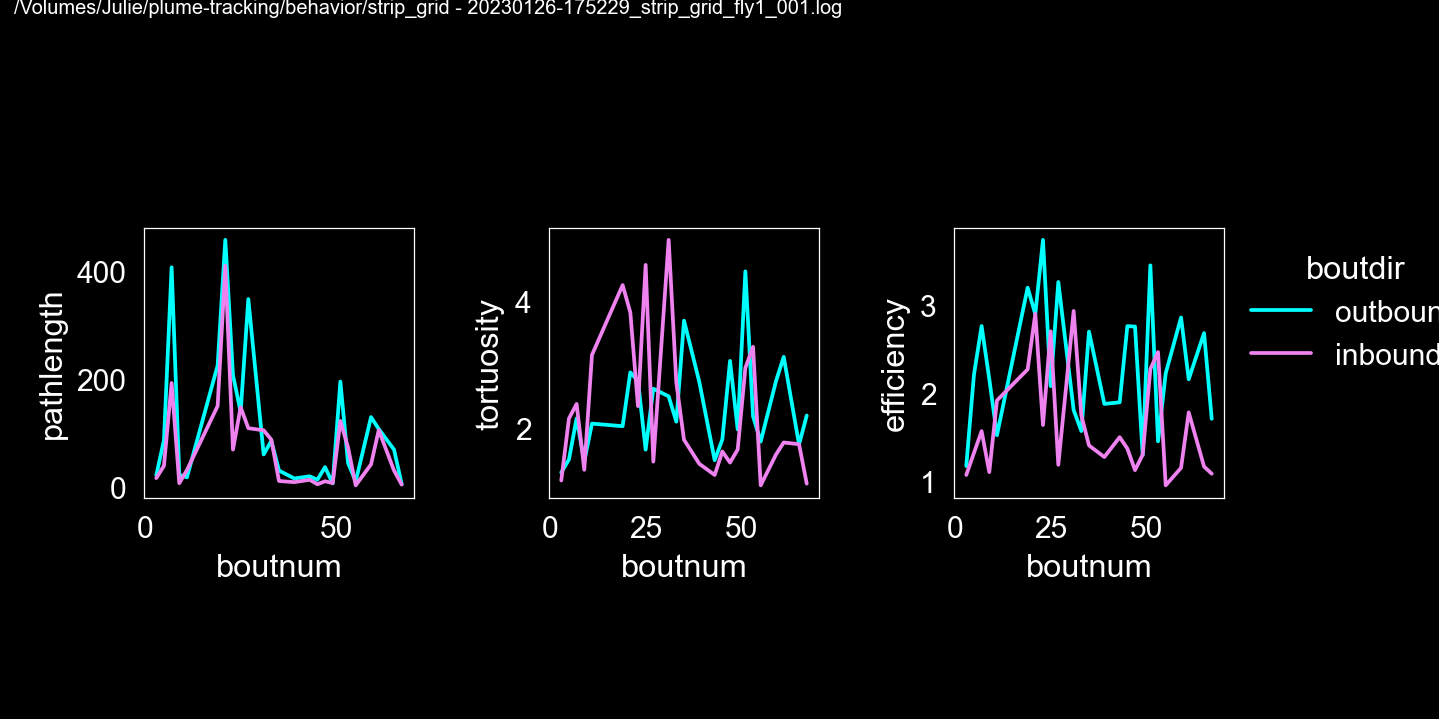

tortuosity-by-boutnum_20230126-175229_strip_grid_fly1_001


In [184]:
fig, axn = pl.subplots(1, 3, figsize=(8,4))
ax=axn[0]
varname = 'pathlength'
# iv = tortdf[tortdf['boutdir']=='inbound'][varname].values
# ov = tortdf[tortdf['boutdir']=='outbound'][varname].values
# boutnums = tortdf[tortdf['boutdir']=='inbound']['boutnum'].values
# ax.plot(boutnums, iv/ov, 'w', label='in/out')
sns.lineplot(data=tortdf, x='boutnum', y='pathlength', 
             hue='boutdir', palette=boutdir_palette, ax=ax)
ax=axn[1]
sns.lineplot(data=tortdf, x='boutnum', y='tortuosity', 
             hue='boutdir', palette=boutdir_palette, ax=ax)
ax=axn[2]
sns.lineplot(data=tortdf, x='boutnum', y='efficiency', 
            hue='boutdir', palette=boutdir_palette, ax=ax)
for ai, ax in enumerate(axn):
    ax.set_box_aspect(1)
    if ax.legend_ is None:
        continue
    if ai==2:
        h, l = ax.get_legend_handles_labels()
        #l = ax.legend_data.keys()
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
    else:
        ax.legend_.remove()
pl.subplots_adjust(left=0.1, right=0.85, wspace=0.5)

util.label_figure(fig, "{} - {}".format(fig_id, fn))
figname = 'tortuosity-by-boutnum_{}'.format(os.path.splitext(fn)[0])
print(figname)
pl.savefig(os.path.join(figdir, '{}.png'.format(figname)), dpi=300)

In [138]:
importlib.reload(butil)
importlib.reload(util)

<module 'utils' from '/Users/julianarhee/Repositories/plume-tracking/utils.py'>

In [139]:
boutdf = butil.get_bout_metrics(df0)

In [143]:
boutdf = df0.groupby('boutnum').apply(butil.get_bout_metrics).unstack().reset_index()

In [144]:
boutdf['boutgroup'] = None
for bi, (b, bd) in enumerate( boutdf[boutdf['instrip']].groupby('boutnum')):
    curr_ix = bd.index.tolist()[0]
    boutdf.loc[curr_ix:curr_ix+1, 'boutgroup'] = bi

In [145]:
boutdf.columns

Index(['boutnum', 'average_ft_heading', 'crosswind_dist_firstlast',
       'crosswind_dist_range', 'crosswind_speed', 'date', 'duration',
       'experiment', 'filename', 'fly_name', 'fpath', 'instrip', 'led_on',
       'n_frames', 'odor_on', 'path_length', 'path_length_x', 'path_length_y',
       'rel_time', 'sig_status', 'speed', 'strip_type', 'trial',
       'upwind_dist_firstlast', 'upwind_dist_range', 'upwind_speed',
       'boutgroup'],
      dtype='object')

<IPython.core.display.Javascript object>


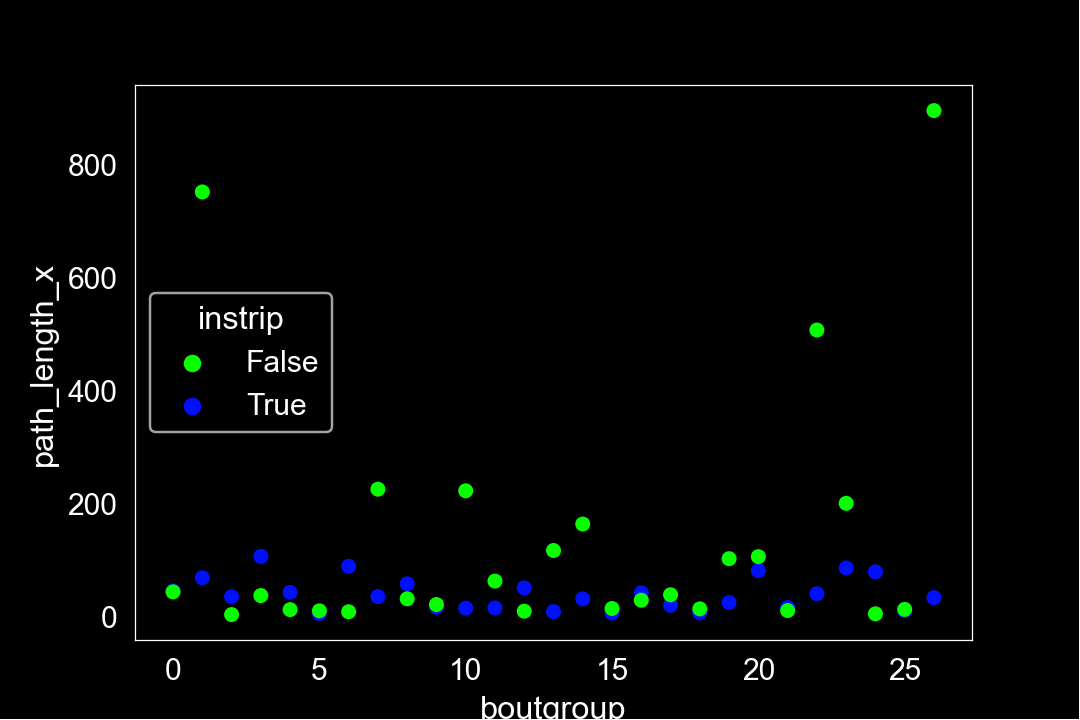

<AxesSubplot: xlabel='boutgroup', ylabel='path_length_x'>

In [146]:
fig, ax = pl.subplots()
sns.scatterplot(data=boutdf, x='boutgroup', y='path_length_x',
               hue='instrip', palette='hsv', ax=ax, edgecolor='none')

In [147]:
   curr_ix

53